### Open test downloaded Powder Patch (and other sites) data from Mesonet 

Notebook contents 
* opening test data download to get a feel of things before downloading many years
* first from only powder patch, then downloading all the nearby sites and plotting

created by Cassie Lumbrazo\
last updated: Jan 2025\
run location: UAS linux\
python environment: **xarray**

In [1]:
# import packages 
%matplotlib inline

# plotting packages }
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import scipy

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
pwd

'/home/cassie/python/repos/juneau_data_analysis'

## Data Source 
So, the API request was not working for Powder Patch. I could only identify the Juneau Airport from that API. Rather, I've downloaded some test data from Mesonet (https://mesonet2.agron.iastate.edu/request/dcp/fe.phtml?network=AK_DCP)

[`PPSA2`] POWDER PATCH STATION (20..)

There are a few stations identifed on Douglas Island, so I think I'll have to download data from each one and put them together to create a complete dataset. 

For now, we can open the one from `PPSA2` to see what variables are in there.

In [4]:
filename = '/home/cassie/data/eaglecrest/mesonet_datadownload_test_powderpatch.txt'

# open
# df = pd.read_csv(filename, skiprows=1, sep='\t', parse_dates=True, index_col='datetime')
df = pd.read_csv(filename, sep = ",")
df

,station,utc_valid,PCIRZZZ,SDIRZZZ,TAIRZZZ,XRIRZZZ
0,PPSA2,2023-10-16 18:00:00,128.62,0.00,49.7,63.04
1,PPSA2,2023-10-16 19:00:00,128.62,0.00,50.5,59.44
2,PPSA2,2023-10-16 20:00:00,128.62,0.00,48.2,72.65
3,PPSA2,2023-10-16 21:00:00,128.62,0.00,48.3,71.85
4,PPSA2,2023-10-16 22:00:00,128.62,0.00,48.4,72.42
...,...,...,...,...,...,...
7627,PPSA2,2024-09-29 20:00:00,278.46,14.36,40.4,91.40
7628,PPSA2,2024-09-29 21:00:00,278.46,16.34,39.9,88.20
7629,PPSA2,2024-09-29 22:00:00,278.46,16.56,40.4,88.60
7630,PPSA2,2024-09-29 23:00:00,278.46,15.25,40.8,88.00


From the SHEF Code Manual (chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.weather.gov/media/mdl/SHEF_CodeManual_5July2012.pdf)

We can get the header info, 
* PCIRZZZ: Accumulated precipitation (in) (PC = PCIRZZZ)
* SDIRZZZ: (not in manual)
* TAIRZZZ: Temperature (DC) (TA = TAIRZZZ)
* XRIRZZZ: (not in manual)

In [5]:
# Trying the variable names here to see what we can fill in based on other code, 
# PCIRZZZ: 24 hour precip
# SDIRZZZ: 24 hour snowfall
# TAIRZZZ: 24 hour max temp
# XRIRZZZ: 24 hour min temp

In [6]:
# make utc_valid a datetime and index the df by it 
df['datetime'] = pd.to_datetime(df['utc_valid'])
df = df.set_index('datetime')
df.head()

,station,utc_valid,PCIRZZZ,SDIRZZZ,TAIRZZZ,XRIRZZZ
datetime,,,,,,
2023-10-16 18:00:00,PPSA2,2023-10-16 18:00:00,128.62,0.0,49.7,63.04
2023-10-16 19:00:00,PPSA2,2023-10-16 19:00:00,128.62,0.0,50.5,59.44
2023-10-16 20:00:00,PPSA2,2023-10-16 20:00:00,128.62,0.0,48.2,72.65
2023-10-16 21:00:00,PPSA2,2023-10-16 21:00:00,128.62,0.0,48.3,71.85
2023-10-16 22:00:00,PPSA2,2023-10-16 22:00:00,128.62,0.0,48.4,72.42


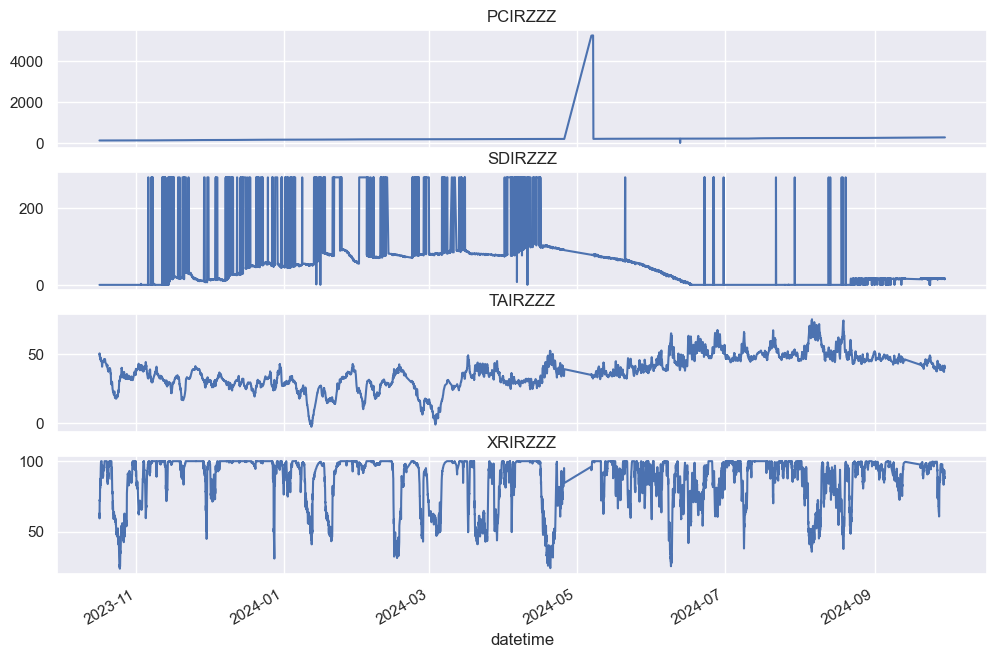

In [7]:
# plot all four variables with datetime to see what they are 
fig, ax = plt.subplots(4,1, figsize=(12,8), sharex=True)
df['PCIRZZZ'].plot(ax=ax[0])
df['SDIRZZZ'].plot(ax=ax[1])
df['TAIRZZZ'].plot(ax=ax[2])
df['XRIRZZZ'].plot(ax=ax[3])

# add titles to all the plots with the variable names 
ax[0].set_title('PCIRZZZ')
ax[1].set_title('SDIRZZZ')
ax[2].set_title('TAIRZZZ')
ax[3].set_title('XRIRZZZ')

plt.show()

It looks like there are some large values in df[`PCIRZZZ`] and df[`SDIRZZZ`] so we will need to remove those to see the data more clearly. But for now it looks like we have, 
* PCIRZZZ: some form of precip 
* SDIRZZZ: total snow depth
* TAIRZZZ: air temperature (avg, min, max idk) in F
* XRIRZZZ: relative humidity 

In [8]:
# drop station and utc_valid columns
df = df.drop(columns=['station', 'utc_valid'])

# rename column names to make this easier 
df.columns = ['pc', 'hs', 'ta', 'rh']
df.head()

,pc,hs,ta,rh
datetime,,,,
2023-10-16 18:00:00,128.62,0.0,49.7,63.04
2023-10-16 19:00:00,128.62,0.0,50.5,59.44
2023-10-16 20:00:00,128.62,0.0,48.2,72.65
2023-10-16 21:00:00,128.62,0.0,48.3,71.85
2023-10-16 22:00:00,128.62,0.0,48.4,72.42


In [9]:
# find where pc is greater than 1000 and make all those values nan in the dataset 
df.loc[df['pc'] > 1000, 'pc'] = np.nan
df.loc[df['pc'] < 100, 'pc'] = np.nan

# make nan where hs is greater than 200
df.loc[df['hs'] > 200, 'hs'] = np.nan
df.loc[df['hs'] < 0, 'hs'] = np.nan

# change ta from F to C 
df['ta'] = (df['ta'] - 32) * 5/9

In [10]:
# convert inches of snow depth to cm 
df['hs_cm'] = df['hs'] * 2.54

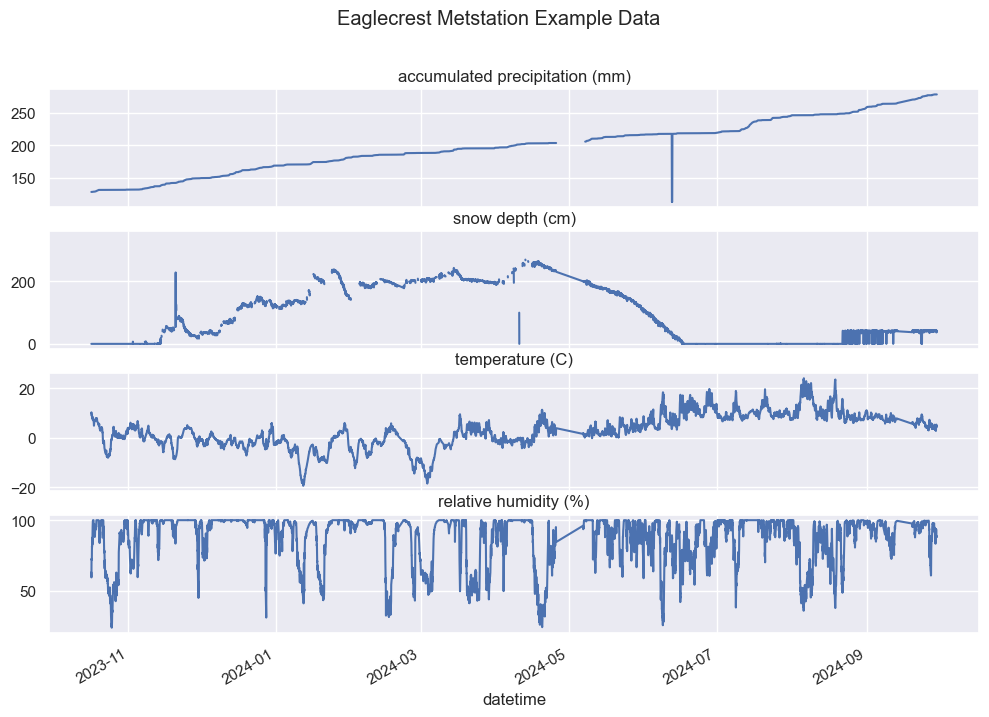

In [11]:
# plot all four variables with datetime to see what they are 
fig, ax = plt.subplots(4,1, figsize=(12,8), sharex=True)
df['pc'].plot(ax=ax[0], label='pc')
df['hs_cm'].plot(ax=ax[1], label='hs')
df['ta'].plot(ax=ax[2], label='ta')
df['rh'].plot(ax=ax[3], label='rh')

# add some titles and labels
# ax[0].set_title('pc: accumulated precipitation (mm)')
# ax[1].set_title('hs: snow depth (cm)')
# ax[2].set_title('ta: temperature (C)')
# ax[3].set_title('rh: relative humidity (%)')

ax[0].set_title('accumulated precipitation (mm)')
ax[1].set_title('snow depth (cm)')
ax[2].set_title('temperature (C)')
ax[3].set_title('relative humidity (%)')

# title
plt.suptitle('Eaglecrest Metstation Example Data')

# add y label 
# ax[0].set_ylabel('mm')
# ax[1].set_ylabel('cm')
# ax[2].set_ylabel('C')
# ax[3].set_ylabel('%')


plt.show()

### From the Mesonet Website, 
#### the following data is all listed from different stations with unique names and station_id
url: https://mesonet2.agron.iastate.edu/request/dcp/fe.phtml?network=AK_DCP

Station 1:
* Name: Douglas - Eaglecrest 
* SID: ETBA2 
* Period: (2015-2022)

Station 2
* Name: Douglas - Eaglecrest 
* SID: JECA2
* Period: (2023- Now)

Station 3
* Name: EAGLECREST TOP
* SID: ECTA2
* Period: (2010 - Now)

Station 4
* Name: Juneau 4SW - Eaglecrest 
* SID: ECEA2
* Period: (2021 - Now)

Station 4
* Name: POWDER PATCH
* SID: PPSA2
* Period: (2010 - Now)

And the data above is from Station 4: Powder Patch, PPSA2

__________________
### So, I've downloaded data from 1 Oct 2023 to 30 Sept 2024 from all of the stations listed above (downloaded together)

Let's take a look at that file and see what's in there...

In [12]:
filename = '/home/cassie/data/eaglecrest/mesonet_datadownload_test_all_eaglecrest_stations.txt'

# open
df = pd.read_csv(filename, sep = ",")
df

,station,utc_valid,PCIRZZZ,PPDRZZZ,PPIRZZZ,PPPRZZZ,PPVRZZZ,PTIRZZZ,PTPRZZZ,SDIRZZZ,...,USPRZZZ,VVIRZZZ,VVPRZZZ,XCIRZZZ,XCPRZZZ,XPPRZZZ,XPQRZZZ,XRIRZZZ,XWIRZZZ,XWPRZZZ
0,ECEA2,2023-10-01 00:00:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
1,ECEA2,2023-10-01 00:05:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2,ECEA2,2023-10-01 00:10:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
3,ECEA2,2023-10-01 00:15:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
4,ECEA2,2023-10-01 00:20:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612832,PPSA2,2024-09-29 20:00:00,278.46,NaN,NaN,NaN,NaN,NaN,NaN,14.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91.4,NaN,NaN
612833,PPSA2,2024-09-29 21:00:00,278.46,NaN,NaN,NaN,NaN,NaN,NaN,16.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.2,NaN,NaN
612834,PPSA2,2024-09-29 22:00:00,278.46,NaN,NaN,NaN,NaN,NaN,NaN,16.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.6,NaN,NaN
612835,PPSA2,2024-09-29 23:00:00,278.46,NaN,NaN,NaN,NaN,NaN,NaN,15.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,NaN,NaN


In [13]:
# make utc_valid a datetime and index the df by it 
df['datetime'] = pd.to_datetime(df['utc_valid'])
df = df.set_index('datetime')
df.head()

,station,utc_valid,PCIRZZZ,PPDRZZZ,PPIRZZZ,PPPRZZZ,PPVRZZZ,PTIRZZZ,PTPRZZZ,SDIRZZZ,...,USPRZZZ,VVIRZZZ,VVPRZZZ,XCIRZZZ,XCPRZZZ,XPPRZZZ,XPQRZZZ,XRIRZZZ,XWIRZZZ,XWPRZZZ
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01 00:00:00,ECEA2,2023-10-01 00:00:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:05:00,ECEA2,2023-10-01 00:05:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:10:00,ECEA2,2023-10-01 00:10:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:15:00,ECEA2,2023-10-01 00:15:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:20:00,ECEA2,2023-10-01 00:20:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN


I think the easiest way to do data exploration here with all the stations together will be with plotly... 

In [14]:
import plotly
import plotly.express as px 

In [15]:
df.station.unique()

array(['ECEA2', 'ECTA2', 'JECA2', 'PPSA2'], dtype=object)

In preliminary plots we had some huge values, so let's just remove those so that we can see the datasets a bit better...

In [16]:
# do a very small cleaning to reduce large errors when plotting
# remove any values in the dataset over 500 
numeric_cols = df.select_dtypes(include=[np.number]).columns # identify the numeric columns only 
df[numeric_cols] = df[numeric_cols].where(df[numeric_cols] < 500, np.nan) # pandas where function keeps values that are true, and replaces values that are false with the value in the third argument

# This does not work because we have some string columns in the dataset
# df.where(df < 500, np.nan, inplace=True) # pandas where function keeps values that are true, and replaces values that are false with the value in the third argument

So, I actually downloaded data from "6" stations. 5 labeled above, then EAGLECREST TOP [`ECTA2`] was listed twice. So based on the fact that there are only 4 unqiue stations, then that means one did not have data from WY2024, which we know is `ETBA2` and the other will be the second `ECTA2`. That checks out. 

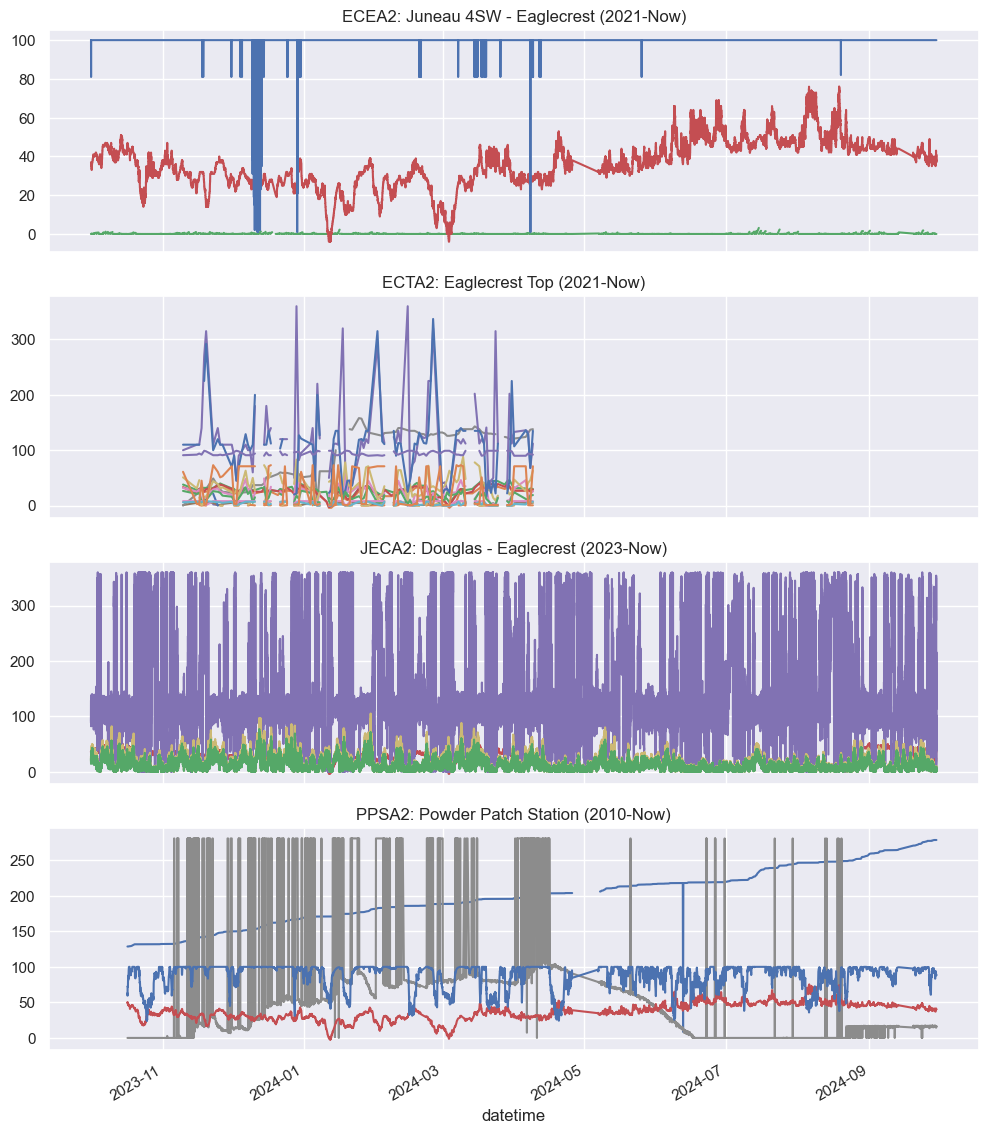

In [17]:
# so let's plot the data by station
fig, ax = plt.subplots(4,1, figsize=(12,15), sharex=True)

df.where(df['station'] == 'ECEA2').plot(ax=ax[0], label='ECEA2', legend=False)
df.where(df['station'] == 'ECTA2').plot(ax=ax[1], label='ECTA2', legend=False)
df.where(df['station'] == 'JECA2').plot(ax=ax[2], label='JECA2', legend=False)
df.where(df['station'] == 'PPSA2').plot(ax=ax[3], label='PPSA2', legend=False)

# add a title for each station name
ax[0].set_title('ECEA2: Juneau 4SW - Eaglecrest (2021-Now)')
ax[1].set_title('ECTA2: Eaglecrest Top (2021-Now)')
ax[2].set_title('JECA2: Douglas - Eaglecrest (2023-Now)')
ax[3].set_title('PPSA2: Powder Patch Station (2010-Now)')

plt.show()

So, we can take a few guesses based on what we see... for most things. For the rest, we checked the data source into provided below. 

### ETBA2: Douglas - Eaglecrest (2015-2022)
*data not downloaded* 

but I do assume that it's a just the older version for the site below (pre-2023)

### JECA2: Douglas - Eaglecrest (2023- Now)
Metasdata Source: https://mesonet2.agron.iastate.edu/sites/current.php?network=AK_DCP&station=JECA2
* TA: temperature, air, dry bulb (unit: F)
* UD: wind direction (unit: degrees)
* UP: peak wind speed (unit: mph)
* US: wind speed (unit: mph)

### ECTA2: EAGLECREST TOP (2010 - Now)
Metadata Source: https://mesonet2.agron.iastate.edu/sites/current.php?network=AK_DCP&station=ECTA2

*all of these precipitation readings are different in duration, 1 day 1 hour 1 week, etc.*
* PP: precipitation (includes liquid amount of new snowfall) (24 hr precipitation, liquid) (in)
* PT: precipitation type 
* SD: snow depth (unit: in)
* SF: snow depth, new snowfall (unit: in) (1 DAY) (24 hr snowfall)
* TA: temperature, air, dry bulb, max of day (unit: F)
* TA: temperature, air, dry bulb, min of day (unit: F)
* TA: temperature, air, dry bulb (unit: F)
* UD: wind direction (unit: degrees)
* UG: wind guest at observation time (unit: mph)
* UP: peak wind speed (unit: mph)

* UR: peak wind direction associated with peak wind speed 
* US: wind speed (unit: mph)
* VV: unknown code, most likely voltage 
* XP: total sky cover (unit: )
* XP: weather, past NWS synoptic code (6 hour)
* XW: weather, present NWS synoptic code (instantaneous) 

SW is not here, but if it was it would be snow water equivalent of the accumulated snow depth of snow on the ground (from Code Manual)


### ECEA2: Juneau 4SW - Eaglecrest (2021 - Now)
Metadata Source: https://mesonet2.agron.iastate.edu/sites/current.php?network=AK_DCP&station=ECEA2
* PP: precipitation (includes liquid amount of new snowfall) (unit: in)
* TA: temperature, air, dry bulb (unit: F)
* XR: relative humidity (unit: %)

### PPSA: POWDER PATCH (2010 - Now)
Metadata Source: https://mesonet2.agron.iastate.edu/sites/current.php?station=PPSA2&network=AK_DCP
* SD: snow depth (unit: in)
* TA: temperature, air, dry bulb (unit: F)
* PC: accumulated precipitation (unit: in)
* XR: relative humidity (unit: %)

In [18]:
# Now, I want to take a look at all the variable names to rename things to make it easier to work with
df.columns

Index(['station', 'utc_valid', 'PCIRZZZ', 'PPDRZZZ', 'PPIRZZZ', 'PPPRZZZ',
       'PPVRZZZ', 'PTIRZZZ', 'PTPRZZZ', 'SDIRZZZ', 'SFDRZZZ', 'SFPRZZZ',
       'SFVRZZZ', 'TAIRZNZ', 'TAIRZXZ', 'TAIRZZZ', 'UDIRZZZ', 'UDPRZZZ',
       'UGIRZZZ', 'UGPRZZZ', 'UPIRZZZ', 'UPPRZZZ', 'URIRZZZ', 'URPRZZZ',
       'USIRZZZ', 'USPRZZZ', 'VVIRZZZ', 'VVPRZZZ', 'XCIRZZZ', 'XCPRZZZ',
       'XPPRZZZ', 'XPQRZZZ', 'XRIRZZZ', 'XWIRZZZ', 'XWPRZZZ'],
      dtype='object')

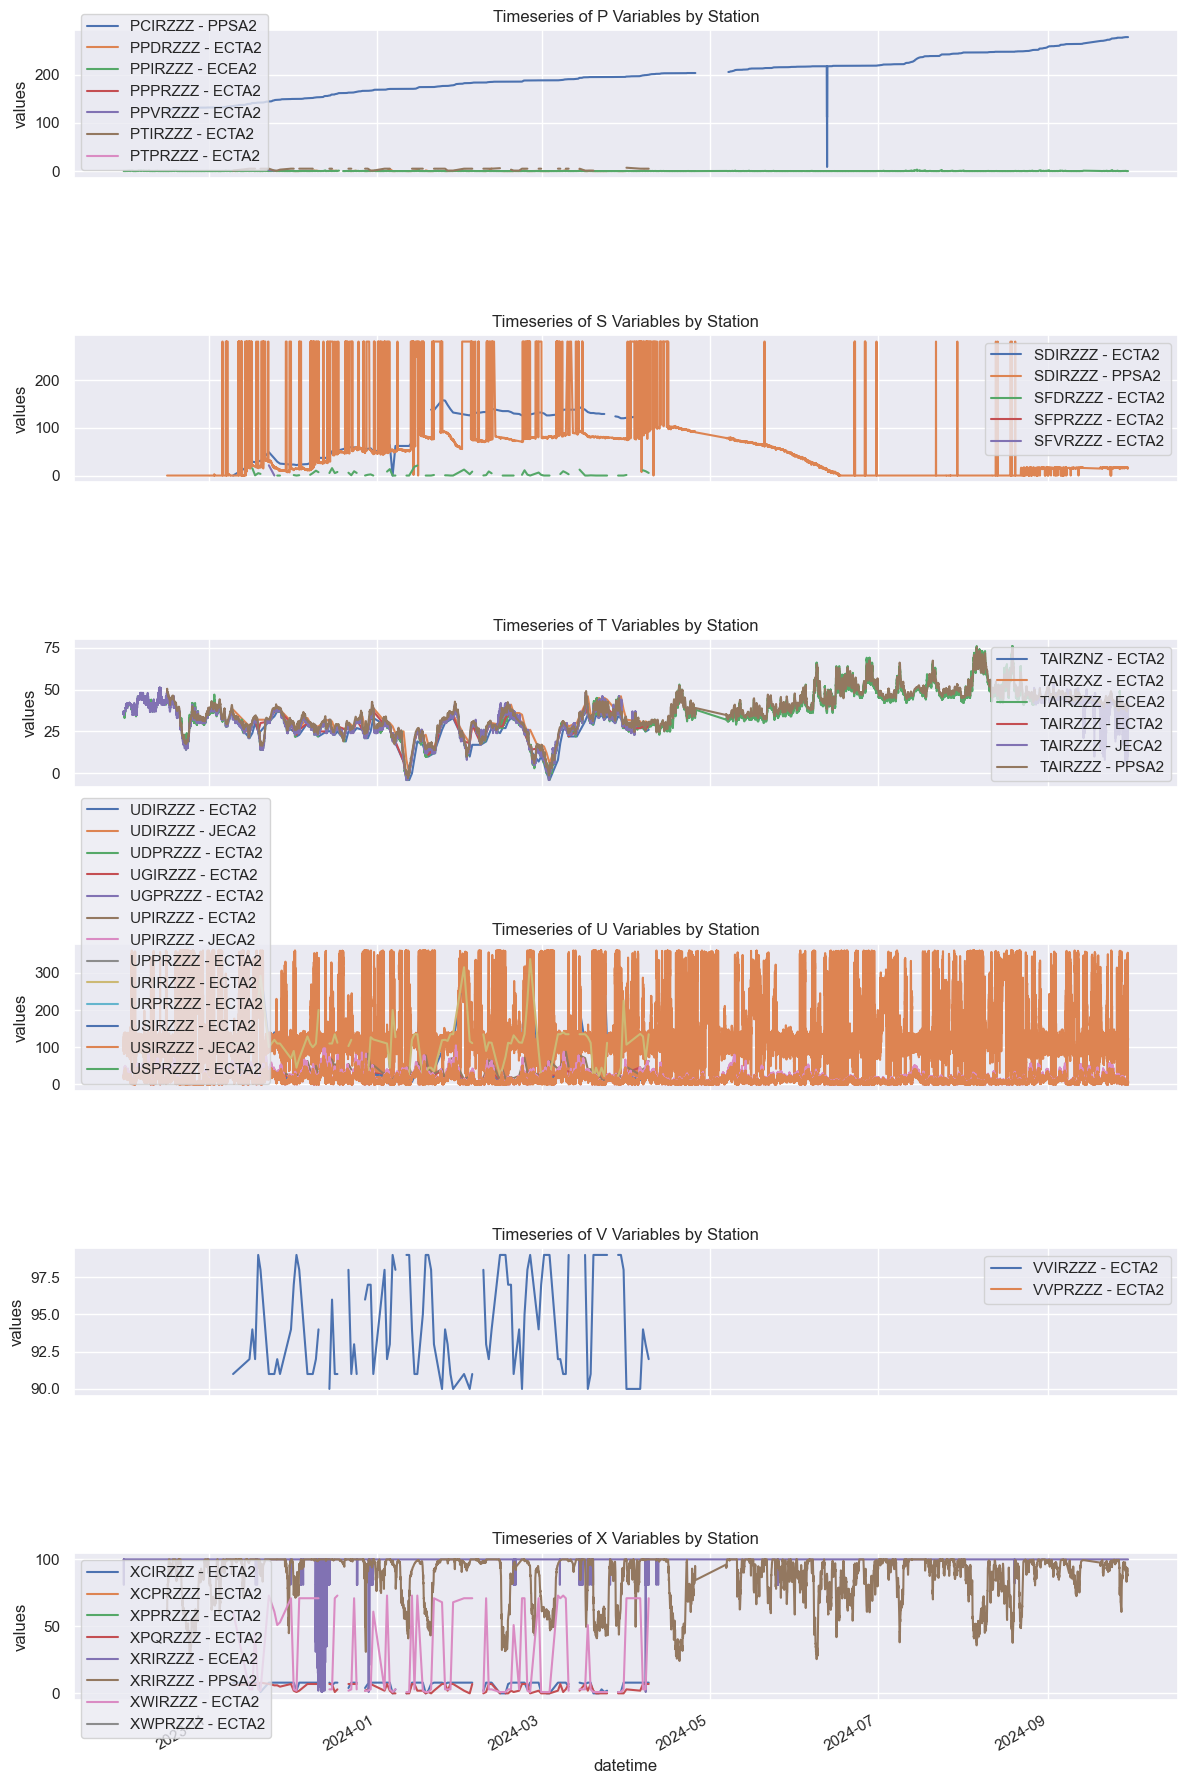

In [19]:
unique_stations = df['station'].unique()

# Create a figure with 5 subplots
fig, ax = plt.subplots(6, 1, figsize=(12, 18), sharex=True)

# Define the variable groups based on their prefixes
variable_groups = {
    'P': ['PCIRZZZ', 'PPDRZZZ', 'PPIRZZZ', 'PPPRZZZ', 'PPVRZZZ', 'PTIRZZZ', 'PTPRZZZ'],
    'S': ['SDIRZZZ', 'SFDRZZZ', 'SFPRZZZ', 'SFVRZZZ'],
    'T': ['TAIRZNZ', 'TAIRZXZ', 'TAIRZZZ'],
    'U': ['UDIRZZZ', 'UDPRZZZ', 'UGIRZZZ', 'UGPRZZZ', 'UPIRZZZ', 'UPPRZZZ', 'URIRZZZ', 'URPRZZZ', 'USIRZZZ', 'USPRZZZ'],
    'V': ['VVIRZZZ', 'VVPRZZZ'],
    'X': ['XCIRZZZ', 'XCPRZZZ', 'XPPRZZZ', 'XPQRZZZ', 'XRIRZZZ', 'XWIRZZZ', 'XWPRZZZ']
}

# Loop through each group and plot the variables
for i, (prefix, variables) in enumerate(variable_groups.items()):
    for var in variables:
        for station in unique_stations:
            # Filter the DataFrame for the current station
            station_data = df[df['station'] == station]
            # Check if the variable exists in the station's data
            if var in station_data.columns and not station_data[var].isnull().all():
                # Plot the variable for the current station
                station_data[var].plot(ax=ax[i], label=f'{var} - {station}')
    
    # Set titles and labels for each subplot
    ax[i].set_title(f'Timeseries of {prefix} Variables by Station')
    ax[i].set_ylabel('values')
    ax[i].legend()

# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')

plt.tight_layout()
plt.show()

Clean this up a bit by removing the V variable entirely, and breaking up the variables further by first and second letters. 

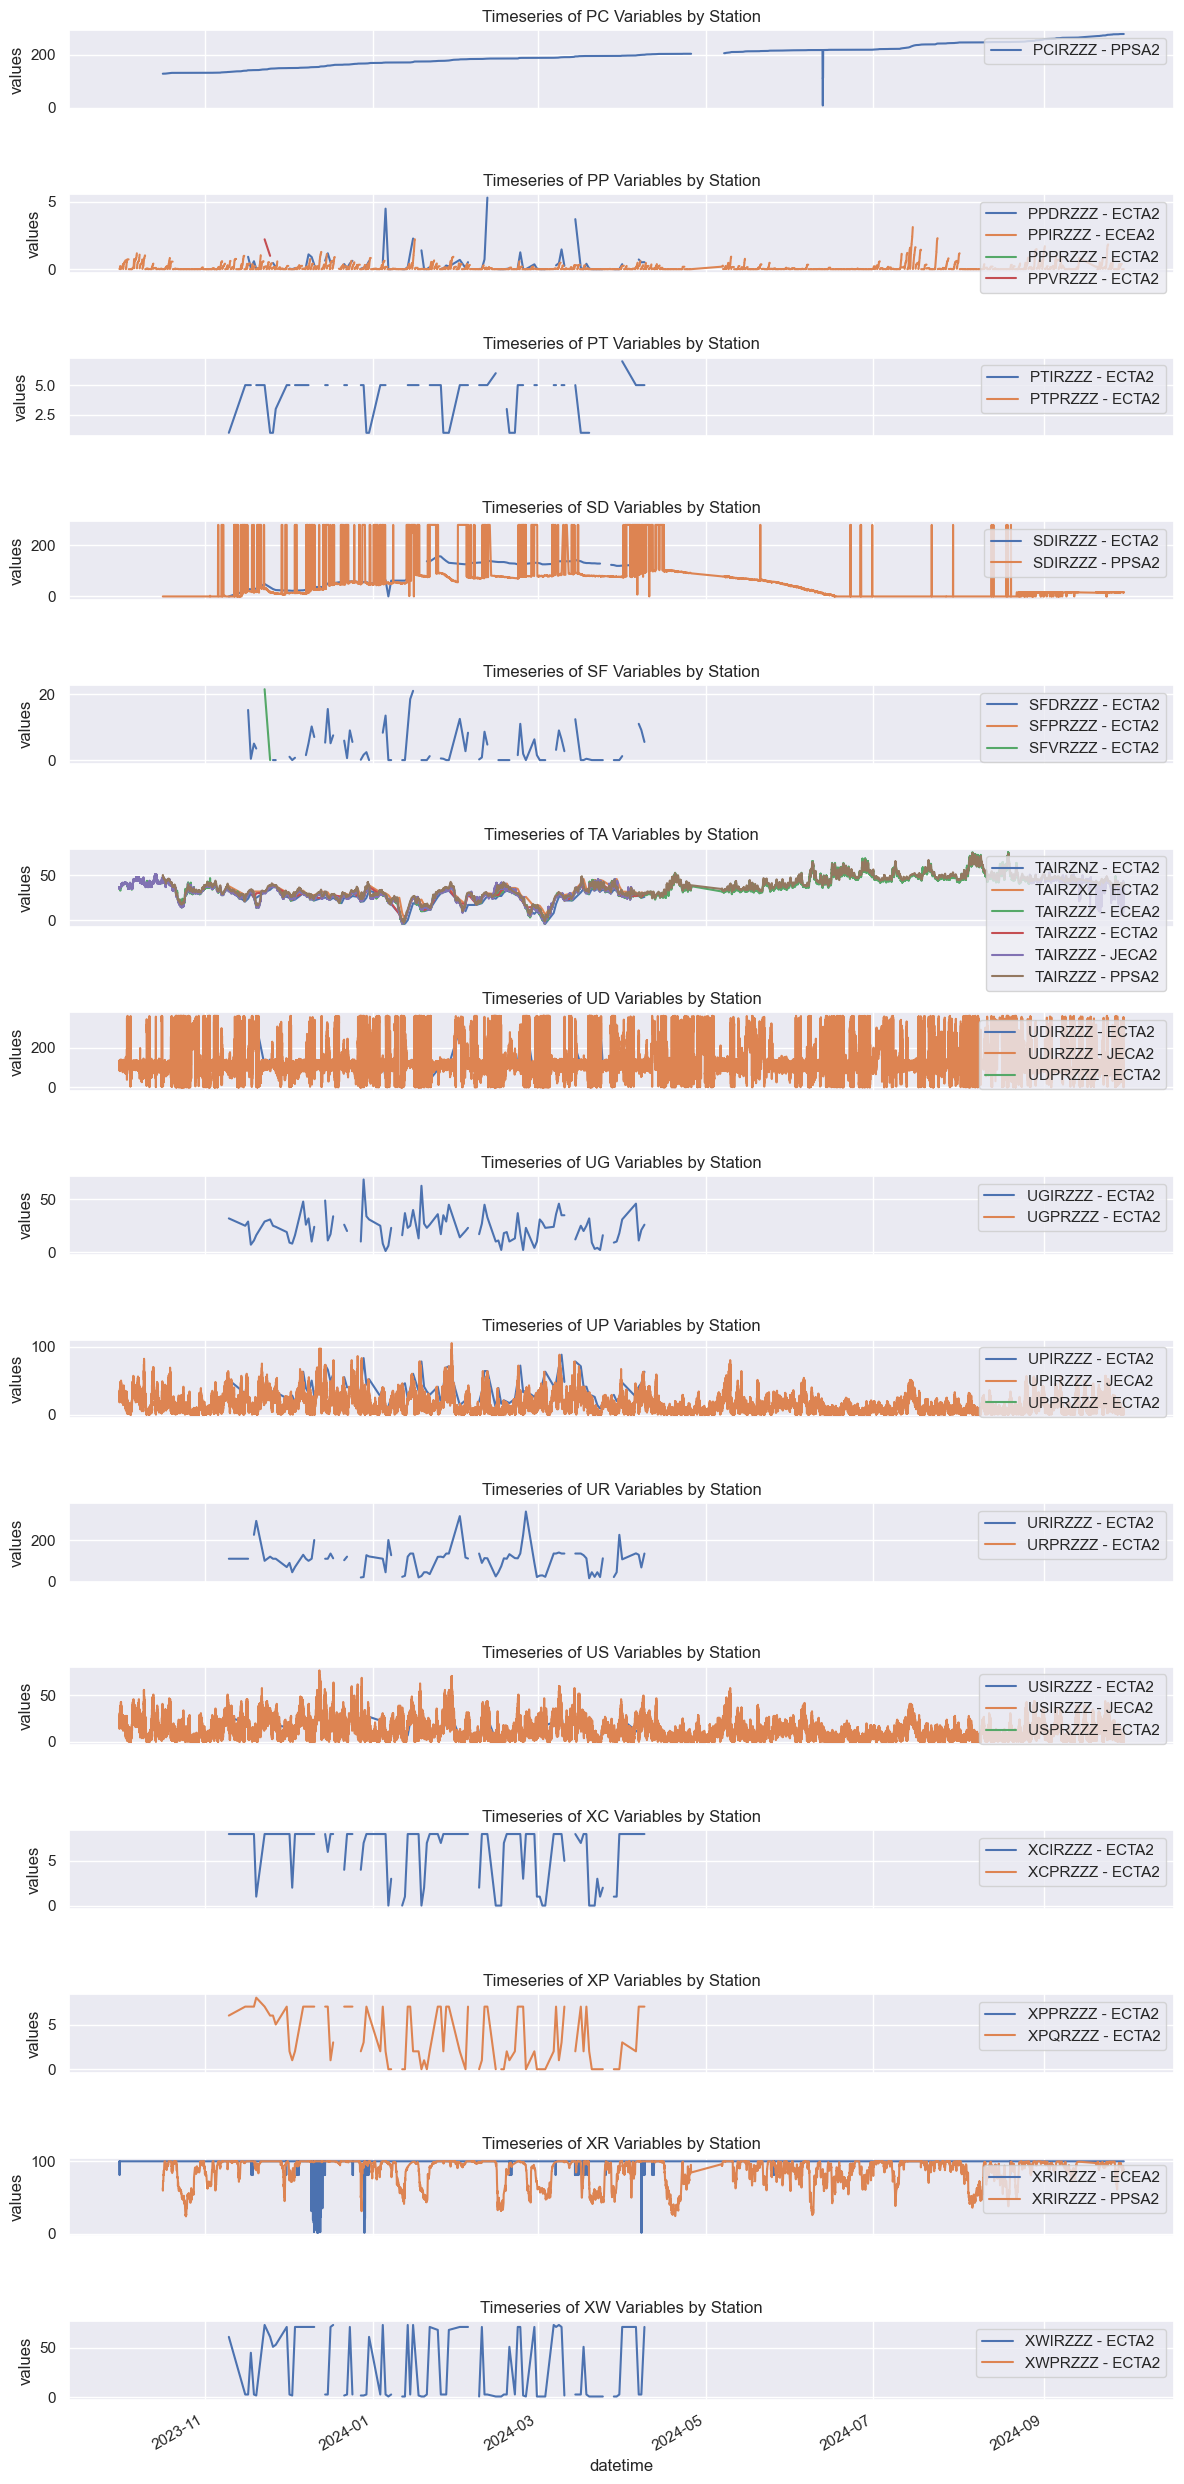

In [20]:
unique_stations = df['station'].unique()

# Create a figure with 5 subplots
fig, ax = plt.subplots(15, 1, figsize=(12, 25), sharex=True)

# Define the variable groups based on their prefixes
variable_groups = {
    'PC': ['PCIRZZZ'],
    'PP': ['PPDRZZZ', 'PPIRZZZ', 'PPPRZZZ', 'PPVRZZZ'],
    'PT': ['PTIRZZZ', 'PTPRZZZ'],
    'SD': ['SDIRZZZ'],
    'SF': ['SFDRZZZ', 'SFPRZZZ', 'SFVRZZZ'],
    'TA': ['TAIRZNZ', 'TAIRZXZ', 'TAIRZZZ'],
    'UD': ['UDIRZZZ', 'UDPRZZZ'],
    'UG': ['UGIRZZZ', 'UGPRZZZ'],
    'UP': ['UPIRZZZ', 'UPPRZZZ'],
    'UR': ['URIRZZZ', 'URPRZZZ'],
    'US': ['USIRZZZ', 'USPRZZZ'],
    # 'V': ['VVIRZZZ', 'VVPRZZZ'], # voltage, not needed to plot anymore
    'XC': ['XCIRZZZ', 'XCPRZZZ'],
    'XP': ['XPPRZZZ', 'XPQRZZZ'],
    'XR': ['XRIRZZZ'],
    'XW': ['XWIRZZZ', 'XWPRZZZ']

}

# Loop through each group and plot the variables
for i, (prefix, variables) in enumerate(variable_groups.items()):
    for var in variables:
        for station in unique_stations:
            # Filter the DataFrame for the current station
            station_data = df[df['station'] == station]
            # Check if the variable exists in the station's data
            if var in station_data.columns and not station_data[var].isnull().all():
                # Plot the variable for the current station
                station_data[var].plot(ax=ax[i], label=f'{var} - {station}')
    
    # Set titles and labels for each subplot
    ax[i].set_title(f'Timeseries of {prefix} Variables by Station')
    ax[i].set_ylabel('values')
    ax[i].legend(loc='upper right')

# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')

plt.tight_layout()
plt.show()

Also, color this by station so we can see the different stations more clearly

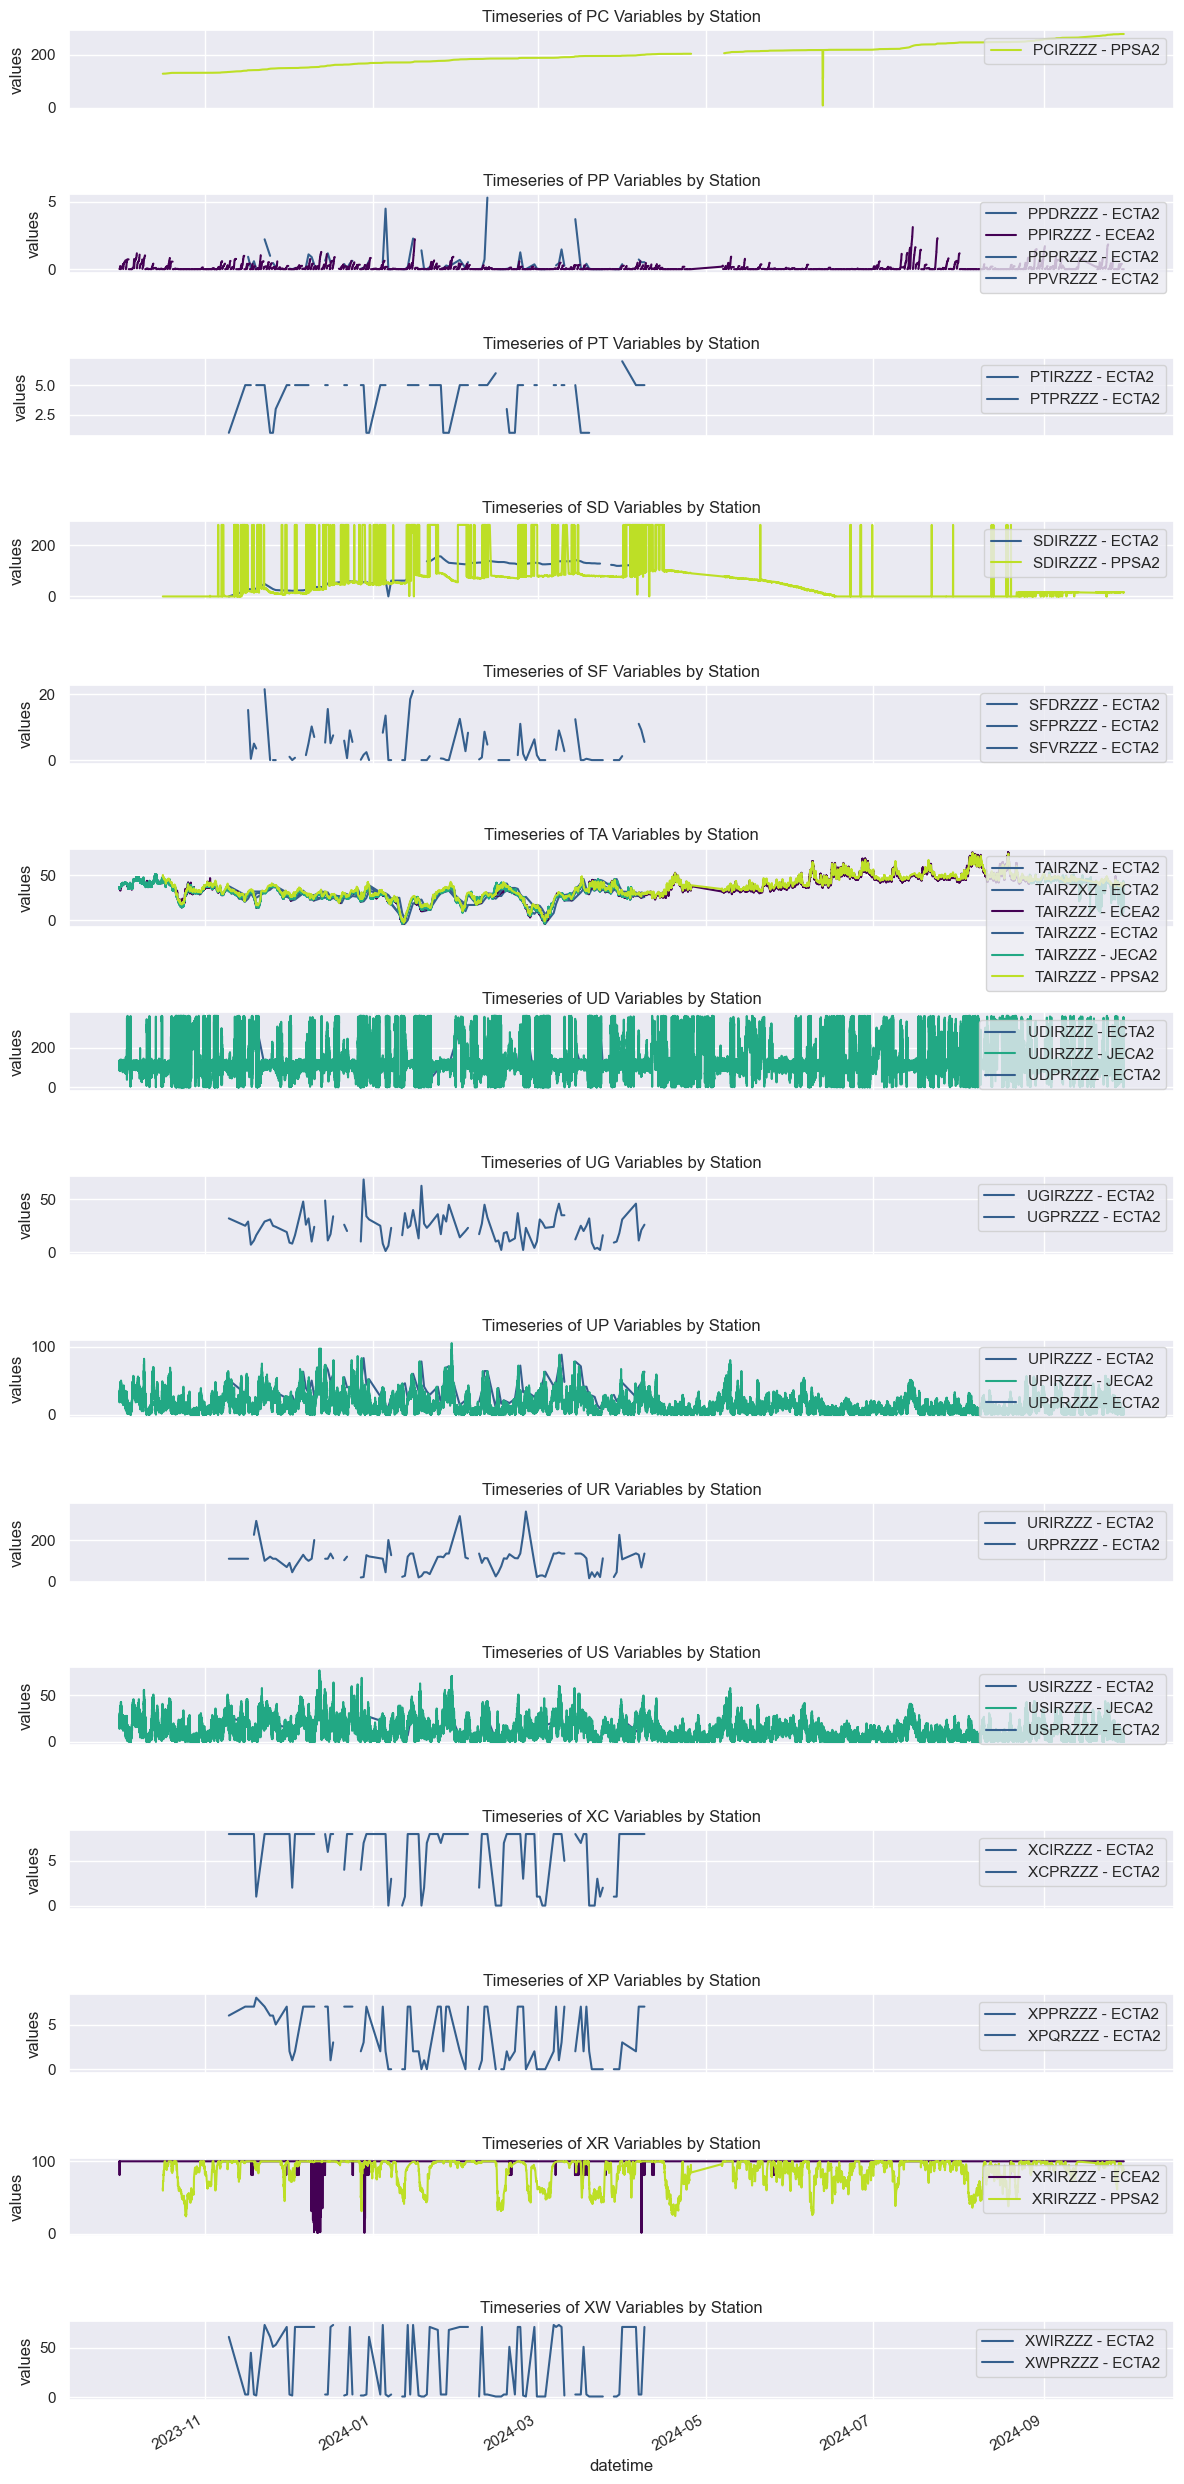

In [21]:
unique_stations = df['station'].unique()

# Create a color map for the unique stations
colors = plt.cm.viridis(np.linspace(0, 0.9, len(unique_stations)))
station_color_map = {station: color for station, color in zip(unique_stations, colors)}

# Create a figure with 14 subplots
fig, ax = plt.subplots(15, 1, figsize=(12, 25), sharex=True)

# Define the variable groups based on their prefixes
variable_groups = {
    'PC': ['PCIRZZZ'],
    'PP': ['PPDRZZZ', 'PPIRZZZ', 'PPPRZZZ', 'PPVRZZZ'], # precipitation (includes liquid amount of new snowfall)
    'PT': ['PTIRZZZ', 'PTPRZZZ'], # precipitation type (0 = none, 1 = rain, 2 = snow, 3 = freezing rain, 4 = ice pellets)
    'SD': ['SDIRZZZ'],
    'SF': ['SFDRZZZ', 'SFPRZZZ', 'SFVRZZZ'],
    'TA': ['TAIRZNZ', 'TAIRZXZ', 'TAIRZZZ'],
    'UD': ['UDIRZZZ', 'UDPRZZZ'],
    'UG': ['UGIRZZZ', 'UGPRZZZ'],
    'UP': ['UPIRZZZ', 'UPPRZZZ'],
    'UR': ['URIRZZZ', 'URPRZZZ'],
    'US': ['USIRZZZ', 'USPRZZZ'],
    # 'V': ['VVIRZZZ', 'VVPRZZZ'], # voltage, not needed to plot anymore
    'XC': ['XCIRZZZ', 'XCPRZZZ'],
    'XP': ['XPPRZZZ', 'XPQRZZZ'],
    'XR': ['XRIRZZZ'],
    'XW': ['XWIRZZZ', 'XWPRZZZ']
}

# Loop through each group and plot the variables
for i, (prefix, variables) in enumerate(variable_groups.items()):
    for var in variables:
        for station in unique_stations:
            # Filter the DataFrame for the current station
            station_data = df[df['station'] == station]
            # Check if the variable exists in the station's data
            if var in station_data.columns and not station_data[var].isnull().all():
                # Plot the variable for the current station with the assigned color
                station_data[var].plot(ax=ax[i], label=f'{var} - {station}', color=station_color_map[station])
    
    # Set titles and labels for each subplot
    ax[i].set_title(f'Timeseries of {prefix} Variables by Station')
    ax[i].set_ylabel('values')
    ax[i].legend(loc='upper right')

# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')

plt.tight_layout()
plt.show()

Okay, now I want to only plot the useful observations from this list. 

These are the ones I will pull in the future data download to clean well and create a complete dataset. 

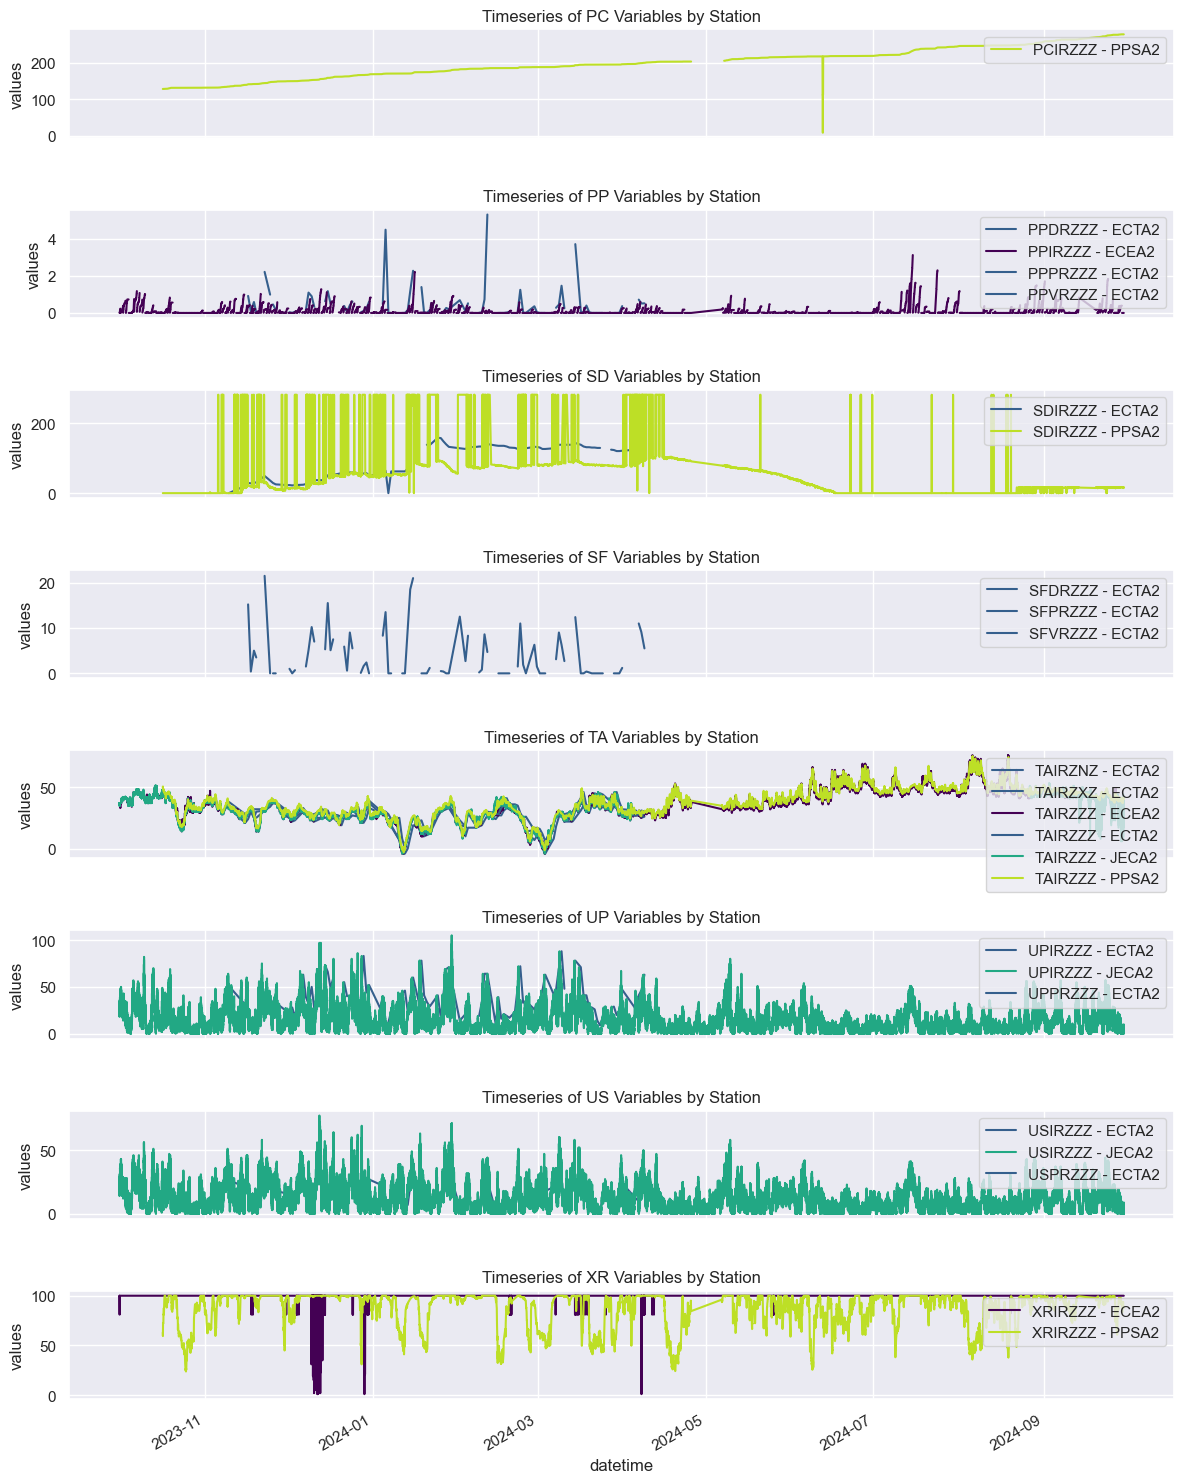

In [22]:
unique_stations = df['station'].unique()

# Create a color map for the unique stations
colors = plt.cm.viridis(np.linspace(0, 0.9, len(unique_stations)))
station_color_map = {station: color for station, color in zip(unique_stations, colors)}

# Create a figure with 14 subplots
fig, ax = plt.subplots(8, 1, figsize=(12, 15), sharex=True)

# Define the variable groups based on their prefixes
variable_groups = {
    'PC': ['PCIRZZZ'], # accumulated precip (in)
    'PP': ['PPDRZZZ', 'PPIRZZZ', 'PPPRZZZ', 'PPVRZZZ'], # precipitation (includes liquid amount of new snowfall)
    # 'PT': ['PTIRZZZ', 'PTPRZZZ'], # precipitation type (0 = none, 1 = rain, 2 = snow, 3 = freezing rain, 4 = ice pellets)
    'SD': ['SDIRZZZ'], # snow depth (in)
    'SF': ['SFDRZZZ', 'SFPRZZZ', 'SFVRZZZ'], # snowfall (in)
    'TA': ['TAIRZNZ', 'TAIRZXZ', 'TAIRZZZ'], # air temperature (F)
    # 'UD': ['UDIRZZZ', 'UDPRZZZ'], # wind direction (degrees)
    # 'UG': ['UGIRZZZ', 'UGPRZZZ'], # wind gust (mph)
    'UP': ['UPIRZZZ', 'UPPRZZZ'], # peak wind speed (mph)
    # 'UR': ['URIRZZZ', 'URPRZZZ'], # peak wind direction associated with peak wind speed 
    'US': ['USIRZZZ', 'USPRZZZ'], # wind speed (mph)
    # 'V': ['VVIRZZZ', 'VVPRZZZ'], # voltage, not needed to plot anymore
    # 'XC': ['XCIRZZZ', 'XCPRZZZ'], # I am not sure, but based on the plot above, it appears to not be useful 
    # 'XP': ['XPPRZZZ', 'XPQRZZZ'], # also weather, but weather past? 
    'XR': ['XRIRZZZ'], # relative humidity (%)
    # 'XW': ['XWIRZZZ', 'XWPRZZZ'] # weather, present? 

}

# Loop through each group and plot the variables
for i, (prefix, variables) in enumerate(variable_groups.items()):
    for var in variables:
        for station in unique_stations:
            # Filter the DataFrame for the current station
            station_data = df[df['station'] == station]
            # Check if the variable exists in the station's data
            if var in station_data.columns and not station_data[var].isnull().all():
                # Plot the variable for the current station with the assigned color
                station_data[var].plot(ax=ax[i], label=f'{var} - {station}', color=station_color_map[station])
    
    # Set titles and labels for each subplot
    ax[i].set_title(f'Timeseries of {prefix} Variables by Station')
    ax[i].set_ylabel('values')
    ax[i].legend(loc='upper right')

# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')

plt.tight_layout()
plt.show()

Some minor cleaning, 

In [23]:
# if the rate of change between two consecutive numbers in the accumulated precip is large, then make it nan because it is likely an error
df['PCIRZZZ'] = df['PCIRZZZ'].where(df['PCIRZZZ'].diff() < 1, np.nan)

# remove the large values in the snow depth, sd 
df['SDIRZZZ'] = df['SDIRZZZ'].where(df['SDIRZZZ'] < 200, np.nan)

In [24]:
# there is one value in the PCIRZZZ which is very small compared to the others, that should be nan 
df['PCIRZZZ'] = df['PCIRZZZ'].where(df['PCIRZZZ'] > 20, np.nan)

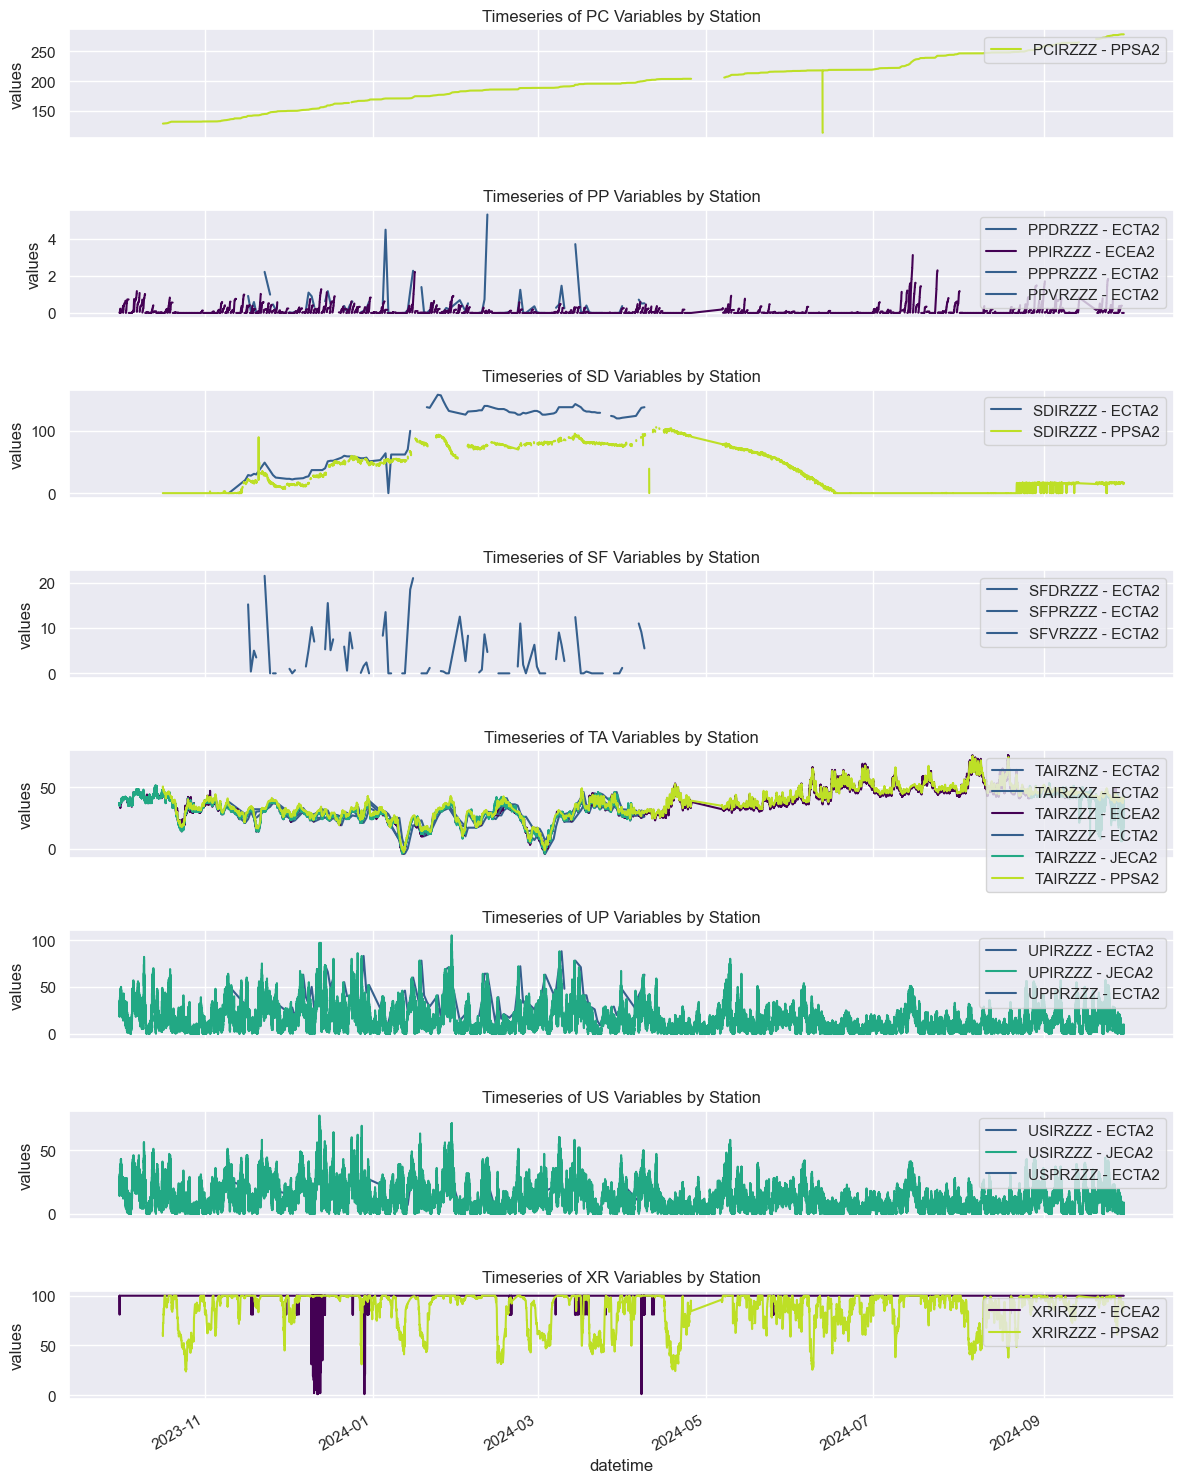

In [25]:
unique_stations = df['station'].unique()

# Create a color map for the unique stations
colors = plt.cm.viridis(np.linspace(0, 0.9, len(unique_stations)))
station_color_map = {station: color for station, color in zip(unique_stations, colors)}

# Create a figure with 14 subplots
fig, ax = plt.subplots(8, 1, figsize=(12, 15), sharex=True)

# Define the variable groups based on their prefixes
variable_groups = {
    'PC': ['PCIRZZZ'], # accumulated precip (in)
    'PP': ['PPDRZZZ', 'PPIRZZZ', 'PPPRZZZ', 'PPVRZZZ'], # precipitation (includes liquid amount of new snowfall)
    # 'PT': ['PTIRZZZ', 'PTPRZZZ'], # precipitation type (0 = none, 1 = rain, 2 = snow, 3 = freezing rain, 4 = ice pellets)
    'SD': ['SDIRZZZ'], # snow depth (in)
    'SF': ['SFDRZZZ', 'SFPRZZZ', 'SFVRZZZ'], # snowfall (in)
    'TA': ['TAIRZNZ', 'TAIRZXZ', 'TAIRZZZ'], # air temperature (F)
    # 'UD': ['UDIRZZZ', 'UDPRZZZ'], # wind direction (degrees)
    # 'UG': ['UGIRZZZ', 'UGPRZZZ'], # wind gust (mph)
    'UP': ['UPIRZZZ', 'UPPRZZZ'], # peak wind speed (mph)
    # 'UR': ['URIRZZZ', 'URPRZZZ'], # peak wind direction associated with peak wind speed 
    'US': ['USIRZZZ', 'USPRZZZ'], # wind speed (mph)
    # 'V': ['VVIRZZZ', 'VVPRZZZ'], # voltage, not needed to plot anymore
    # 'XC': ['XCIRZZZ', 'XCPRZZZ'], # I am not sure, but based on the plot above, it appears to not be useful 
    # 'XP': ['XPPRZZZ', 'XPQRZZZ'], # also weather, but weather past? 
    'XR': ['XRIRZZZ'], # relative humidity (%)
    # 'XW': ['XWIRZZZ', 'XWPRZZZ'] # weather, present? 

}

# Loop through each group and plot the variables
for i, (prefix, variables) in enumerate(variable_groups.items()):
    for var in variables:
        for station in unique_stations:
            # Filter the DataFrame for the current station
            station_data = df[df['station'] == station]
            # Check if the variable exists in the station's data
            if var in station_data.columns and not station_data[var].isnull().all():
                # Plot the variable for the current station with the assigned color
                station_data[var].plot(ax=ax[i], label=f'{var} - {station}', color=station_color_map[station])
    
    # Set titles and labels for each subplot
    ax[i].set_title(f'Timeseries of {prefix} Variables by Station')
    ax[i].set_ylabel('values')
    ax[i].legend(loc='upper right')

# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')

plt.tight_layout()
plt.show()

A closer look at the precip variables to see how they compare...

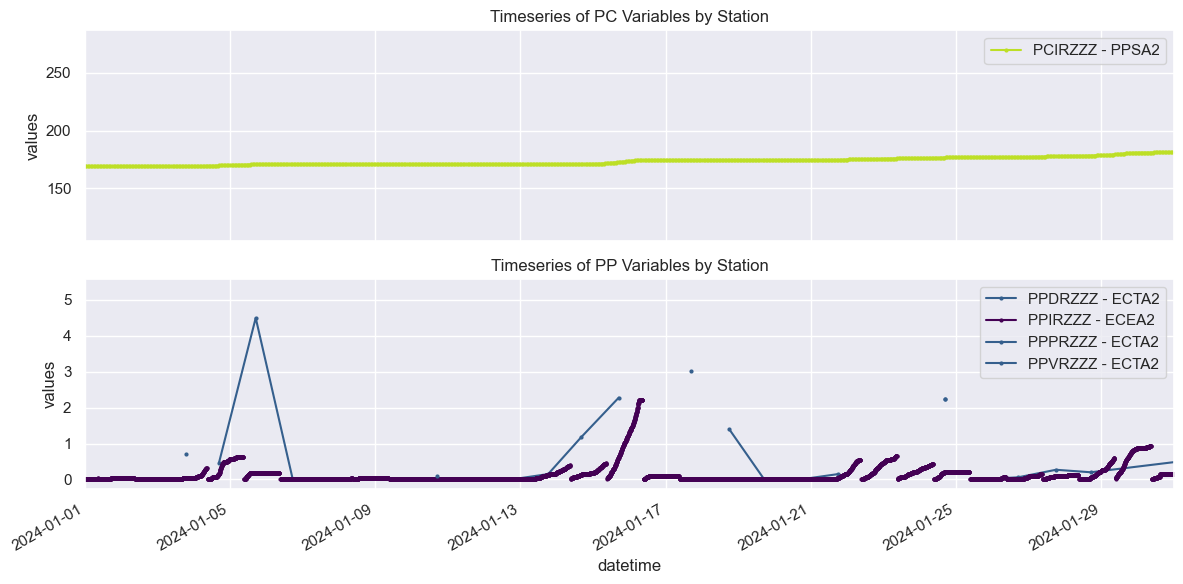

In [30]:
unique_stations = df['station'].unique()

# Create a color map for the unique stations
colors = plt.cm.viridis(np.linspace(0, 0.9, len(unique_stations)))
station_color_map = {station: color for station, color in zip(unique_stations, colors)}

# Create a figure with 14 subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Define the variable groups based on their prefixes
variable_groups = {
    'PC': ['PCIRZZZ'], # accumulated precip (in)
    'PP': ['PPDRZZZ', 'PPIRZZZ', 'PPPRZZZ', 'PPVRZZZ'], # precipitation (includes liquid amount of new snowfall)
    # 'PT': ['PTIRZZZ', 'PTPRZZZ'], # precipitation type (0 = none, 1 = rain, 2 = snow, 3 = freezing rain, 4 = ice pellets)
    # 'SD': ['SDIRZZZ'], # snow depth (in)
    # 'SF': ['SFDRZZZ', 'SFPRZZZ', 'SFVRZZZ'], # snowfall (in)
    # 'TA': ['TAIRZNZ', 'TAIRZXZ', 'TAIRZZZ'], # air temperature (F)
    # 'UD': ['UDIRZZZ', 'UDPRZZZ'], # wind direction (degrees)
    # 'UG': ['UGIRZZZ', 'UGPRZZZ'], # wind gust (mph)
    # 'UP': ['UPIRZZZ', 'UPPRZZZ'], # peak wind speed (mph)
    # 'UR': ['URIRZZZ', 'URPRZZZ'], # peak wind direction associated with peak wind speed 
    # 'US': ['USIRZZZ', 'USPRZZZ'], # wind speed (mph)
    # 'V': ['VVIRZZZ', 'VVPRZZZ'], # voltage, not needed to plot anymore
    # 'XC': ['XCIRZZZ', 'XCPRZZZ'], # I am not sure, but based on the plot above, it appears to not be useful 
    # 'XP': ['XPPRZZZ', 'XPQRZZZ'], # also weather, but weather past? 
    # 'XR': ['XRIRZZZ'], # relative humidity (%)
    # 'XW': ['XWIRZZZ', 'XWPRZZZ'] # weather, present? 

}

# Loop through each group and plot the variables
for i, (prefix, variables) in enumerate(variable_groups.items()):
    for var in variables:
        for station in unique_stations:
            # Filter the DataFrame for the current station
            station_data = df[df['station'] == station]
            # Check if the variable exists in the station's data
            if var in station_data.columns and not station_data[var].isnull().all():
                # Plot the variable for the current station with the assigned color
                station_data[var].plot(ax=ax[i], label=f'{var} - {station}', color=station_color_map[station], marker='o', markersize=2)
    
    # Set titles and labels for each subplot
    ax[i].set_title(f'Timeseries of {prefix} Variables by Station')
    ax[i].set_ylabel('values')
    ax[i].legend(loc='upper right')

# Set common x-label for all subplots
ax[-1].set_xlabel('datetime')

# zoom into a few days only 
start_date = '2024-01-01'
end_date = '2024-01-31'
ax[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))
# Set the x-axis major locator to show every 2 days
# ax[0].xaxis.set_major_locator(ticker.DayLocator(interval=2))
# Set the x-axis major formatter to show the date in a readable format
# ax[0].xaxis.set_major_formatter(ticker.DateFormatter('%Y-%m-%d'))

plt.tight_layout()
plt.show()

In [32]:
df.head()

,station,utc_valid,PCIRZZZ,PPDRZZZ,PPIRZZZ,PPPRZZZ,PPVRZZZ,PTIRZZZ,PTPRZZZ,SDIRZZZ,...,USPRZZZ,VVIRZZZ,VVPRZZZ,XCIRZZZ,XCPRZZZ,XPPRZZZ,XPQRZZZ,XRIRZZZ,XWIRZZZ,XWPRZZZ
datetime,,,,,,,,,,,,,,,,,,,,,
2023-10-01 00:00:00,ECEA2,2023-10-01 00:00:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:05:00,ECEA2,2023-10-01 00:05:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:10:00,ECEA2,2023-10-01 00:10:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:15:00,ECEA2,2023-10-01 00:15:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
2023-10-01 00:20:00,ECEA2,2023-10-01 00:20:00,NaN,NaN,0.01,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN


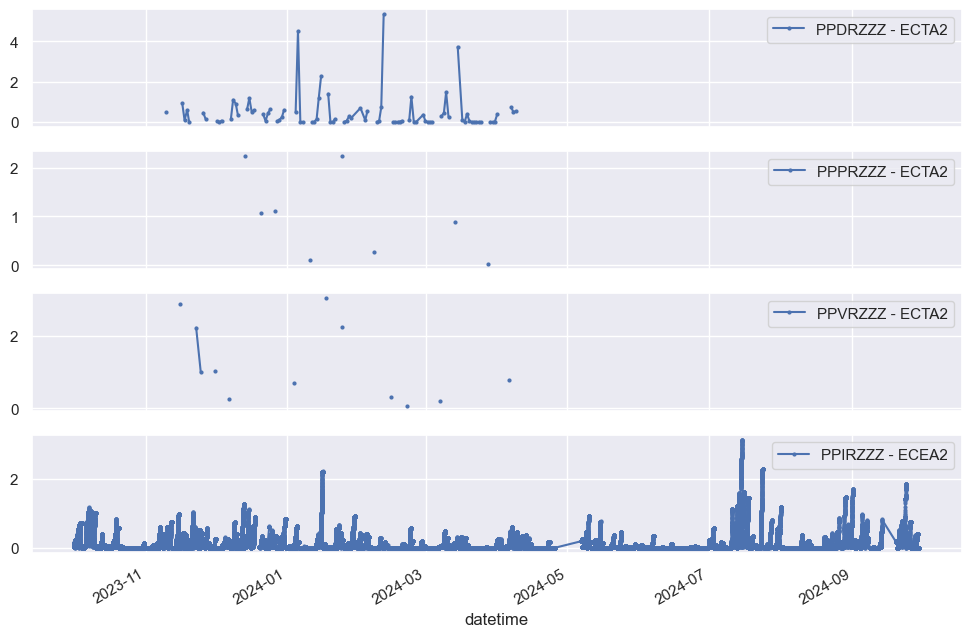

In [37]:
# we want to isolate the few variables 
# make subplots 
fig, ax = plt.subplots(4,1, figsize=(12,8), sharex=True)
df['PPDRZZZ'].where(df['station'] == 'ECTA2').plot(ax=ax[0], marker='o', markersize=2, label='PPDRZZZ - ECTA2')
df['PPPRZZZ'].where(df['station'] == 'ECTA2').plot(ax=ax[1], marker='o', markersize=2, label='PPPRZZZ - ECTA2')
df['PPVRZZZ'].where(df['station'] == 'ECTA2').plot(ax=ax[2], marker='o', markersize=2, label='PPVRZZZ - ECTA2')
df['PPIRZZZ'].where(df['station'] == 'ECEA2').plot(ax=ax[3], marker='o', markersize=2, label='PPIRZZZ - ECEA2')

# set a legend on all plots 
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
ax[2].legend(loc='upper right')
ax[3].legend(loc='upper right')

So it looks like `PPIRZZZ - ECEA2` is the reliable precipitation here...

From here I see ECEA2 Eaglecrest Ptarmigan Top CWOP (ECEA2) 
* Precipitation since local midnight (in)
* Precipitation Accumulated Over Period Shown (in)

(np.float64(19726.0), np.float64(19730.0))

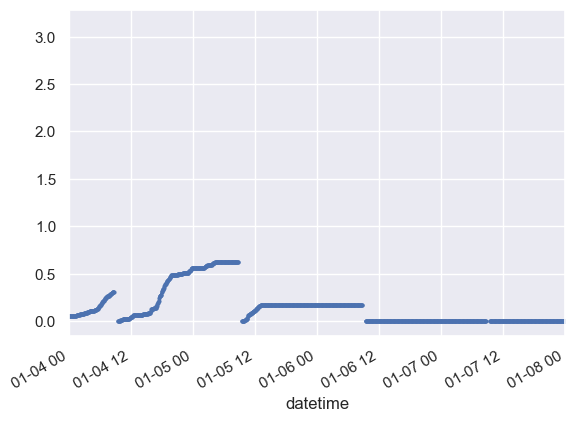

In [43]:
df['PPIRZZZ'].where(df['station'] == 'ECEA2').plot(marker='o', markersize=2, label='PPIRZZZ - ECEA2')

# plot only a few days 
start_date = '2024-01-04'
end_date = '2024-01-8'
plt.xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

Okay, this looks pretty good. I should be able to take the precipitation since local midnight and create an hourly precipitation dataset.

(0.0, 2.0)

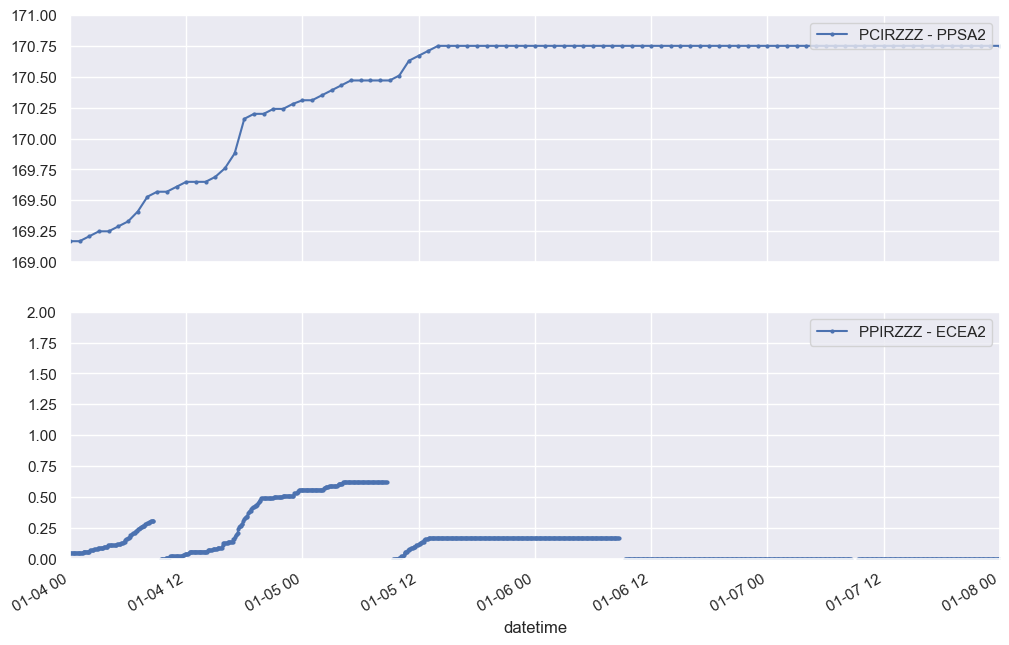

In [51]:
# we want to isolate the few variables 
# make subplots 
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
df['PCIRZZZ'].where(df['station'] == 'PPSA2').plot(ax=ax[0], marker='o', markersize=2, label='PCIRZZZ - PPSA2')
df['PPIRZZZ'].where(df['station'] == 'ECEA2').plot(ax=ax[1], marker='o', markersize=2, label='PPIRZZZ - ECEA2')

# set a legend on all plots 
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

# plot only a few days 
start_date = '2024-01-04'
end_date = '2024-01-8'
ax[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# limit y axis
# ax[0].set_ylim(172, 175) # 10 inches perhaps 
ax[0].set_ylim(169, 171) # 10 inches perhaps 
ax[1].set_ylim(0, 2)

(0.0, 2.0)

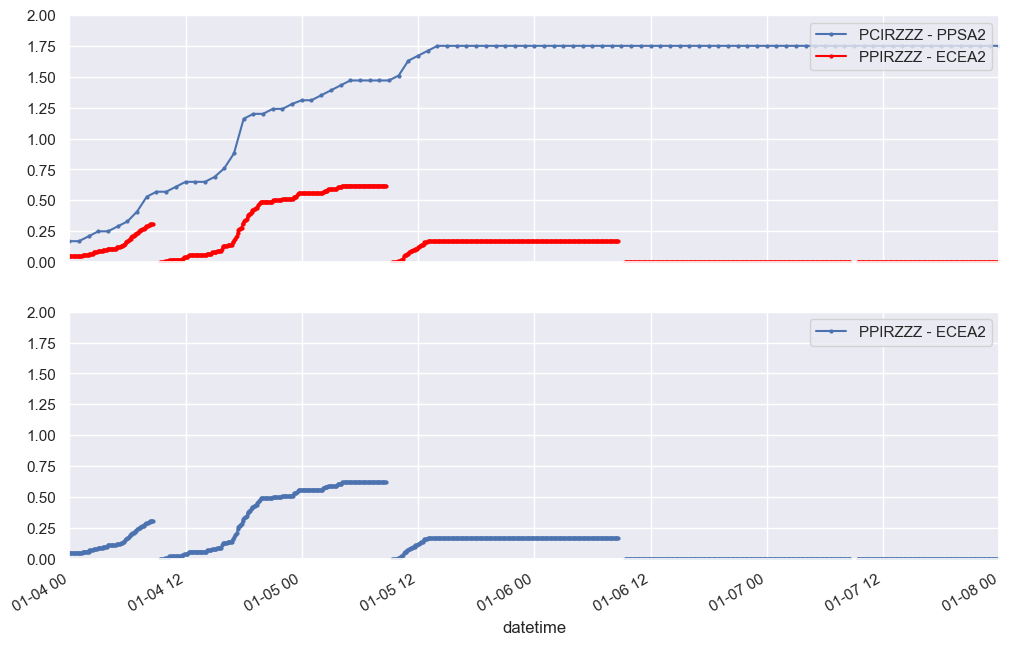

In [62]:
# x = df['PPIRZZZ'].where(df['station'] == 'ECEA2').cumsum()

# we want to isolate the few variables 
# make subplots 
fig, ax = plt.subplots(2,1, figsize=(12,8), sharex=True)
(df['PCIRZZZ'].where(df['station'] == 'PPSA2')-169).plot(ax=ax[0], marker='o', markersize=2, label='PCIRZZZ - PPSA2')
df['PPIRZZZ'].where(df['station'] == 'ECEA2').plot(ax=ax[0], marker='o', markersize=2, label='PPIRZZZ - ECEA2', color='red')


df['PPIRZZZ'].where(df['station'] == 'ECEA2').plot(ax=ax[1], marker='o', markersize=2, label='PPIRZZZ - ECEA2')

# set a legend on all plots 
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

# plot only a few days 
start_date = '2024-01-04'
end_date = '2024-01-8'
ax[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# limit y axis
# ax[0].set_ylim(172, 175) # 10 inches perhaps 
ax[0].set_ylim(0, 2) 
ax[1].set_ylim(0, 2)


(-0.5, 2.0)

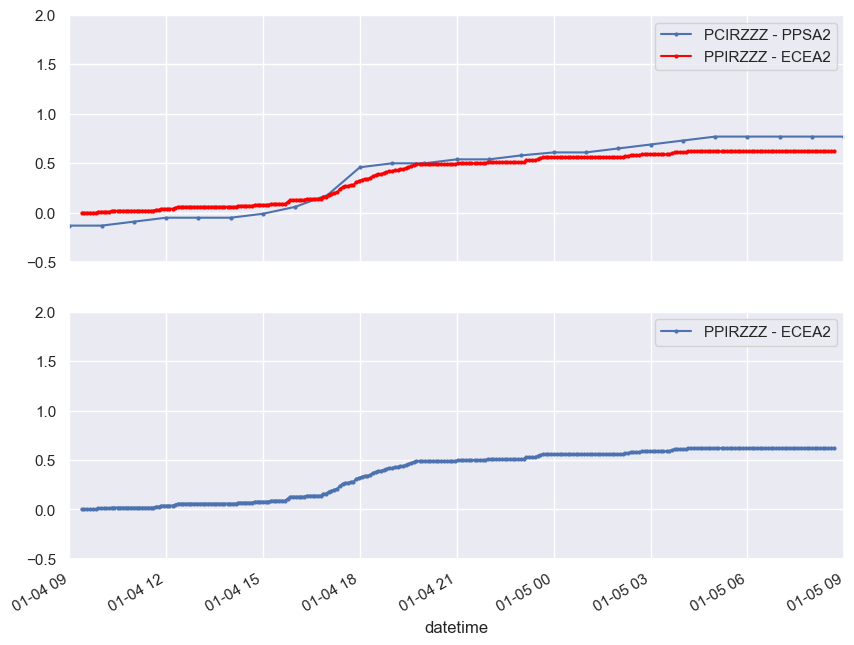

In [68]:
# x = df['PPIRZZZ'].where(df['station'] == 'ECEA2').cumsum()

# we want to isolate the few variables 
# make subplots 
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
(df['PCIRZZZ'].where(df['station'] == 'PPSA2')-169.7).plot(ax=ax[0], marker='o', markersize=2, label='PCIRZZZ - PPSA2')
df['PPIRZZZ'].where(df['station'] == 'ECEA2').plot(ax=ax[0], marker='o', markersize=2, label='PPIRZZZ - ECEA2', color='red')


df['PPIRZZZ'].where(df['station'] == 'ECEA2').plot(ax=ax[1], marker='o', markersize=2, label='PPIRZZZ - ECEA2')

# set a legend on all plots 
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

# plot only a few days 
start_date = '2024-01-04 09:00'
end_date = '2024-01-05 09:00'
ax[0].set_xlim(pd.to_datetime(start_date), pd.to_datetime(end_date))

# limit y axis
# ax[0].set_ylim(172, 175) # 10 inches perhaps 
ax[0].set_ylim(-0.5, 2) 
ax[1].set_ylim(-0.5, 2)


## Notes for Future Data Cleaning
* dealing with units, everything from NWS comes in F/mph/in 
* dealing with temporal resolution of the datasets 
    * I noticed some are at 15m temporal res, but regardless, when I make a final cleaned `df` for use, we can convert all to hourly

### Wind Rose Plot

<Axes: xlabel='datetime'>

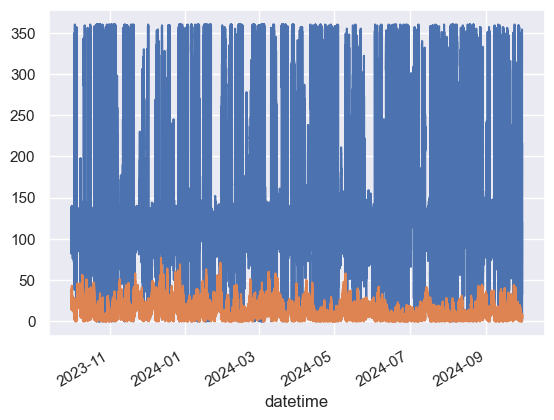

In [41]:
df['UDIRZZZ'].where(df['station'] == 'JECA2').plot()
df['USIRZZZ'].where(df['station'] == 'JECA2').plot()

Speed Bins: [ 0.  15.4 30.8 46.2 61.6 77. ]
Shape of wind_rose: (16, 5)


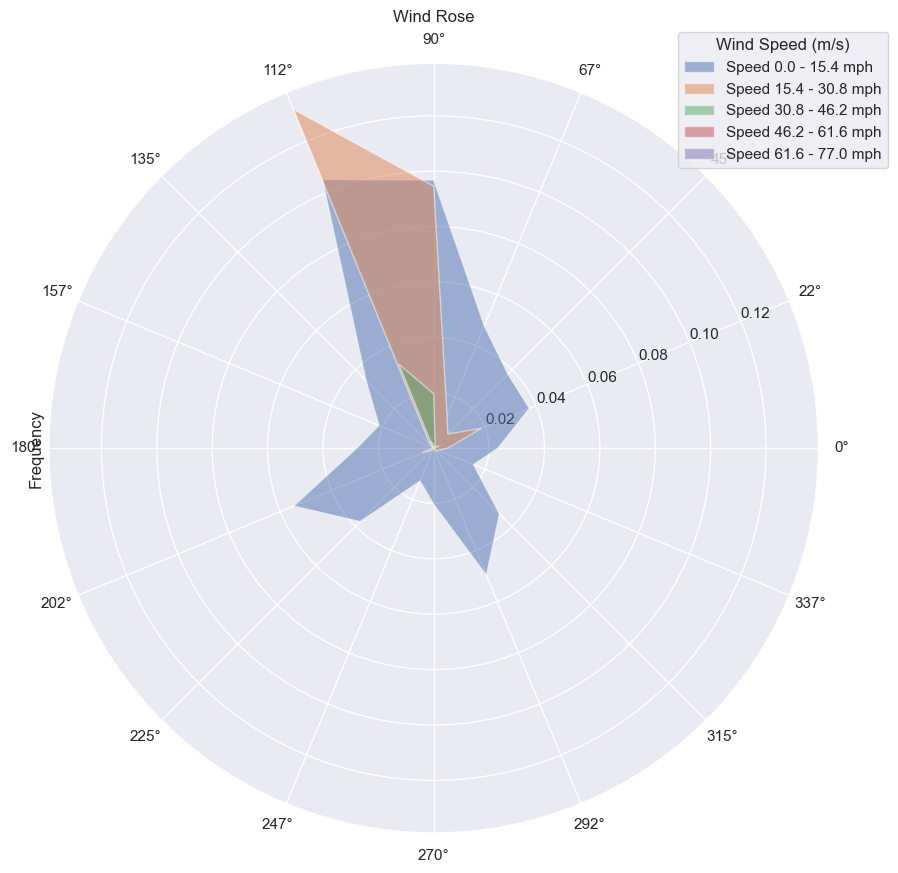

In [78]:
wind_direction = df['UDIRZZZ'].where(df['station'] == 'JECA2').reset_index(drop=True)
wind_speed = df['USIRZZZ'].where(df['station'] == 'JECA2').reset_index(drop=True)

# Combine the two series into a DataFrame, aligning them by index
df_wind = pd.concat([wind_direction, wind_speed], axis=1)
df_wind.columns = ['wind_direction', 'wind_speed']

# Drop rows where both wind_direction and wind_speed are NaN
df_wind.dropna(subset=['wind_direction', 'wind_speed'], how='all', inplace=True)

# Now we can create the wind rose plot
# Define the number of bins for wind speed and direction
num_direction_bins = 16  # 22.5 degrees each (360/16)
num_speed_bins = 5  # Adjust based on your data range

# Create bins for wind direction and speed
direction_bins = np.linspace(0, 360, num_direction_bins + 1)
speed_bins = np.linspace(0, df_wind['wind_speed'].max(), num_speed_bins + 1)

# Print the speed_bins to check how many bins are created
print("Speed Bins:", speed_bins)

# Create a 2D histogram
wind_rose, _, _ = np.histogram2d(df_wind['wind_direction'], df_wind['wind_speed'], bins=[direction_bins, speed_bins])

# Normalize the histogram to get frequencies
wind_rose = wind_rose / wind_rose.sum()

# Print the shape of wind_rose to check the number of speed bins
print("Shape of wind_rose:", wind_rose.shape)

# Create the wind rose plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Define the angles for the wind directions
angles = np.deg2rad(direction_bins[:-1])  # Convert to radians

# Plot each wind speed bin
for i in range(num_speed_bins):
    # Create a polygon for each wind speed bin
    # We need to create a full array for the fill, including the last point to close the polygon
    if i == 0:
        ax.fill(angles, wind_rose[:, i], alpha=0.5, label=f'Speed {speed_bins[i]:.1f} - {speed_bins[i+1]:.1f} mph')
    else:
        ax.fill(angles, wind_rose[:, i], alpha=0.5, label=f'Speed {speed_bins[i]:.1f} - {speed_bins[i+1]:.1f} mph')

# Customize the plot
ax.set_xticks(angles)  # Set the direction ticks
ax.set_xticklabels([f'{int(angle)}°' for angle in direction_bins[:-1]])  # Set the direction labels
ax.set_title('Wind Rose', va='bottom')
ax.set_ylabel('Frequency')

# Add a legend
ax.legend(title='Wind Speed (m/s)', bbox_to_anchor=(1.1, 1.05))

plt.show()